In [9]:
### Util for the KMC code with numpy vectorisation :>
import numpy as np
import sys
import math
import random
from tqdm.auto import tqdm

# Init File for the KMC Python package
Xup = 0
Tup = 1
Tdn = 2
Xdn = 3
Ndirs = 4

COLDLAT = 0
HOTLAT = 1
PLUS = 1
MINUS = -1

FRESH = 0
FORGET = 1
FRESHHOT = 2
MAXFILENAME = 256

lattice = None

Nx = None
Nt = None
N = None
Volume = None
Nf = None
G = None
Step = None
Warmup = None
NMdtraj = None
Mdstep = None
max_hmc_iter = None
Nmeas = None
Measlen = None
CgiterH = None
CgiterP = None
ResidueH = None
ResidueP = None

sites_on_node = None

readflag = None
saveflag = None
read_binary_sigma = None # Although defined as char array we take string
save_binary_sigma = None # Although defined as char array we take string

av_sigma = None #Defined as pointer check later !!!!

iseed = None
junk_id = None

N_POINTERS = 4

gen_pt = None
neighbor = None # neighbour stores the index of the neighbouring site in place of the pointer

#-----------------------
IM1 = 2147483563
IM2 = 2147483399
AM = 1.0 / IM1
IMM1 = IM1 - 1
IA1 = 40014
IA2 = 40692
IQ1 = 53668
IQ2 = 52774
IR1 = 12211
IR2 = 3791
NTAB = 32
NDIV = 1 + IMM1 / NTAB
EPS = 1.2e-7
RNMX = 1.0 - EPS
#-----------------------
# These are the static variable defined inside the codebase
iset = 0
gset = None
iseed = -772
iseed2 = 123456789
iy = 0
iv = [0] * NTAB


class LATTICE:
    def __init__(self,volume_):
        self.x = np.array(list(0 for i in range(volume_)))
        self.t = np.array(list(0 for i in range(volume_)))
        self.index = np.array(list(0 for i in range(volume_)))
        self.sign = np.array(list(0 for i in range(volume_)))

        self.mom = np.array(list(0.0 for i in range(volume_)))
        self.pi = np.array(list(0.0 for i in range(volume_)))
        self.sigma = np.array(list(0.0 for i in range(volume_)))
        self.phi = np.array(list(0.0 for i in range(volume_)))
        self.rho = np.array(list(0.0 for i in range(volume_)))

        self.eta = np.array(list(list(0.0 for i in range(4)) for j in range(volume_)))
        self.zeta = np.array(list(list(0.0 for i in range(4)) for j in range(volume_)))

        self.omega = np.array(list(list(0.0 for i in range(4)) for j in range(volume_)))
        self.xi = np.array(list(list(0.0 for i in range(4)) for j in range(volume_)))

        self.p = np.array(list(0.0 for i in range(volume_)))
        self.r = np.array(list(0.0 for i in range(volume_)))
        self.mp = np.array(list(0.0 for i in range(volume_)))
        self.mmp = np.array(list(0.0 for i in range(volume_)))

    def __getitem__(self,key):
        return self.__dict__[key]
    def __setitem__(self,key,value):
        self.__dict__[key] = value

class params:
    def __init__(self):
        self.stopflag = None
        self.iseed = None
        self.nx = None
        self.nt = None
        self.nflv = None
        self.g = None
        self.step = None
        self.eps = None
        self.krmax = None
        self.krtraj = None
        self.cgiter1 = None
        self.cgiter2 = None

        self.residue1 = None
        self.residue2 = None

        self.read_sigma = None
        self.save_sigma = None

        self.read_bin_double = None
        self.save_binary_double = None

par_buf = params()

def setup():
    prompt = initial_set()
    setup_layout()
    make_lattice()
    make_nn_gathers()

    return prompt


def initial_set():
    global Nx
    global Nt
    global N
    global Volume

    prompt = getprompt()

    print("GN model with HMC algorithm\n")
    print("Alpha machine, Version 1\n")
    print("type 0 for no prompts, 1 for prompts or 2 for list of prompts\n")

    prompt = getprompt() #Using the direct value inplace of the pointer in the original code base

#     Nx = get_i(prompt, "nx")
    Nx = 16
#     Nt = get_i(prompt, "nt")
    Nt = 16
    if Nx == Nt:
        N = Nx
    else:
        print("Nx and Nt must be same, exiting")
        sys.exit()

    Volume = Nx*Nt
    print(f"Lattice dimensions = {Nx} {Nt}\n")

    return prompt

def readin(prompt):
    global Nf, G, Step, Eps, NMdtraj, KRmax, Measlen, CgiterH, ResidueH, CgiterP, ResidueP, max_hmc_iter, Mdstep
#     Nf = get_i(prompt, "num_flavors")
#     G = get_lf(prompt, "coupling")
#     Step = get_lf(prompt, "step_size")
#     Eps = get_lf(prompt, "noise_parameter")
#     KRtraj = get_i(prompt, "kr_trajectory_length")
#     KRmax = get_i(prompt, "kr_refreshing_steps")
#     Measlen = get_i(prompt, "measurement_interval")
#     CgiterH = get_i(prompt, "max_cg_iter_for_hamil")
#     ResidueH = get_lf(prompt, "residue_cg_hamil")
#     CgiterP = get_i(prompt, "max_cg_iter_for_piup")
#     ResidueP = get_lf(prompt, "residue_cg_piup")

    Nf = 4
    G = 0.54
    Step = 0.02
    Eps = 1.5
    NMdtraj = 300
    Mdstep = 50
    max_hmc_iter = 1000
    KRmax = 2
    Measlen = 1
    CgiterH = 20000
    ResidueH = 0.000001
    CgiterP = 10000
    ResidueP = 0.0001

def make_lattice():

    global lattice, Volume, Nx, neighbor

    lattice = LATTICE(Volume)
    neighbor = np.array(list(list(0.0 for i in range(Volume)) for j in range(4)))

    for t_ in range(Nt):
        for x_ in range(Nx):
            i = site_index(x_,t_)     # Function not defined yet !!!!
            lattice.x[i] = x_
            lattice.t[i] = t_
            lattice.index[i] = x_+Nx*t_
            if t_%2 ==0:
                lattice.sign[i] = 1
            else:
                lattice.sign[i] = -1

def setup_layout():
    global Volume, sites_on_node
    sites_on_node = Volume

def get_lf(prompt,variable_name_string):

    if prompt == 1:
        x = float(input(f"enter {variable_name_string}"))
        return(x)

    else:
        print("Change Prompt type currently not supported")
        system.exit()


def get_i(prompt, variable_name_string):

    if prompt == 1:
        x = int(input(f"enter {variable_name_string}"))
        return(x)

    else:
        print("Change Prompt type currently not supported")
        system.exit()


def getprompt():
#     prompt = int(input("Enter the prompt type (only 1 is supported for now):"))
    prompt = 1
    return prompt

def average_sigma():
    global Volume, lattice

    av_sigma = None
    t_sigma = None
    t_sigma = 0

    t_sigma = np.sum(lattice.sigma[:])
    av_sigma = t_sigma/Volume
    return av_sigma


def average_pbp():

    print("check this function with sir")


def congrad(src,dest,cgiter,residue,cgflag,flv):
    niter = None
    i = None
    size_src = None
    cp = None
    d = None
    dsize_r = None
    dsize_src = None
    size_r = None
    a = None
    b = None
    c = None

    global Volume
    global lattice

    dsize_src = 0

    dsize_src = np.sum((lattice[src][:, flv])**2)
    size_src = math.sqrt(dsize_src)

    if cgflag == 0:

        lattice[dest][:,flv] = 0
        lattice.r[:] = lattice[src][:,flv]
        lattice.p[:] = lattice.r[:]

        dsize_r = 1
        size_r = dsize_r

    if cgflag != 0:
        matp2d(dest, "mp", PLUS, flv)
        matd2d("mp", "mmp", MINUS)

        dsize_r = 0

        lattice.r[:] = lattice[src][:,flv] - lattice.mmp[:]
        dsize_r = np.sum(lattice.r[:]**2)
        lattice.p[:] = lattice.r[:]

        size_r = math.sqrt(dsize_r)/size_src

    cp = dsize_r

    niter = 0

    while niter < cgiter and size_r > residue:
        c = cp

        matd2d("p","mp",PLUS)
        matd2d("mp","mmp",MINUS)

        d=0
        d = np.sum((lattice.p[:]*lattice.mmp[:]))
        a = c/d

        cp = 0
        lattice[dest][:,flv] = lattice[dest][:,flv] + a*lattice.p[:]
        lattice.r[:] = lattice.r[:] - a*lattice.mmp[:]
        cp = np.sum(lattice.r[:]**2)

        b = cp/c
        dsize_r = 0

        lattice.p[:] = lattice.r[:] + b*lattice.p[:]
        dsize_r = np.sum(lattice.r[i]**2)
        size_r = math.sqrt(dsize_r)/size_src

        niter = niter + 1

    if size_r > residue:
        # print("CG_MD Not Converged")
        system.exit(1)

def matd2d(src,dest,isign):
    i = None
    n = None

    global Xup,Xdn,Tup,Tdn, volume, lattice

    gather(src, Xup, gen_pt)
    lattice[dest][:] = 0.5*lattice.sign[:]*gen_pt[:]

    gather(src, Xdn, gen_pt)
    lattice[dest][:] = lattice[dest][:] - 0.5*lattice.sign[:] * gen_pt[:]

    gather(src, Tup, gen_pt)
    lattice[dest][:] = lattice[dest][:] + 0.5 * gen_pt[:]

    gather(src, Tdn, gen_pt)
    lattice[dest][:] = lattice[dest][:] - 0.5 * gen_pt[:]

    lattice[dest][:] = isign*(lattice[dest][:]) + (lattice.phi[:])*(lattice[src][:])


def matd2p(src, dest, isign, flavor):
    i = None
    n = None

    global Xup, Xdn, gen_pt, Tdn, Tup, lattice

    gather(src, Xup, gen_pt)
    lattice[dest][i,flavor] = lattice.sign[:] * 0.5 * gen_pt[:]

    gather(src, Xdn, gen_pt)
    lattice[dest][:,flavor] = lattice[dest][:,flavor] - 0.5*lattice.sign[:] * gen_pt[:]

    gather(src, Tup, gen_pt)
    lattice[dest][:,flavor] = lattice[dest][:,flavor] + 0.5 * gen_pt[:]

    gather(src, Tdn, gen_pt)
    lattice[dest][:,flavor] = lattice[dest][:,flavor] - 0.5 * gen_pt[:]

    lattice[dest][:,flavor] = isign*lattice[dest][:,flavor] + lattice.phi[:]*lattice[src][:]


def matp2d(src,dest,isign,flavor):

    global Xup,gen_pt, Xdn, Tdn, Tup, lattice

    gather(src, Xup, gen_pt)
    lattice[dest][:] = 0.5*lattice.sign[:] * gen_pt[:,flavor]

    gather(src, Xdn, gen_pt)
    lattice[dest][:] = lattice[dest][:] - 0.5 * lattice.sign[:] * gen_pt[:,flavor]

    gather(src, Tup, gen_pt)
    lattice[dest][:] =  lattice[dest][:] + 0.5 * gen_pt[:,flavor]

    gather(src, Tdn, gen_pt)
    lattice[dest][:] = lattice[dest][:] - 0.5 * gen_pt[:,flavor]

    lattice[dest][:] = isign*lattice[dest][:] +lattice.phi[:]*lattice[src][:,flavor]



def matp2p(src,dest,isign,flav):

    global Xup, Xdn, Tup, Tdn, gen_pt, lattice

    gather(src, Xup, gen_pt)
    lattice[dest][:,flav] = lattice.sign[:] * 0.5 * gen_pt[:,flav]

    gather(src, Xdn, gen_pt)
    lattice[dest][:,flav] -= lattice.sign[:] * 0.5 * gen_pt[:,flav]

    gather(src, Tup, gen_pt)
    lattice[dest][:,flav] +=  0.5 * gen_pt[:,flav]

    gather(src, Tdn, gen_pt)
    lattice[dest][:,flav] -=  0.5 * gen_pt[:,flav]


    lattice[dest][:,flav] = isign*(lattice[dest][:,flav]) + (lattice.phi[:])*(lattice[src][:,flav])





def nn_coords(x,t,dir):
    global neighbor
    xp = x
    tp = t

    global Nx, Nt

    if dir == 0:
        xp = (x+1)%Nx
    if dir == 3:
        xp = (x+Nx-1)%Nx
    if dir == 1:
        tp = (t+1)%Nt
    if dir == 2:
        tp = (t+Nt-1)%Nt
    return xp, tp

def make_nn_gathers():

    #This will run only once hence not vectorised

    global neighbor, lattice, Volume
    i = None
    j = None
    dir = None

    xpt = None
    tpt = None
    mul = None

    for dir in range(0,4):
        for i in range(Volume):
            xpt, tpt = nn_coords(lattice.x[i],lattice.t[i], dir)
            j = site_index(xpt,tpt)
            neighbor[dir,i] = j
    neighbor = neighbor.astype(np.uint16)


def gather(field, index, dest):

    global neighbor, lattice
    global gen_pt
    gen_pt = lattice[field][neighbor[index,:]].copy()


def hmc():
    global lattice, Nf, MINUS, max_hmc_iter, Mdstep, Step

    i, j, nf, ctr = 0, 0, 0, 0
    hold, hnew, deltah = 0.0, 0.0, 0.0
    xx = 1.0
    z = 0
    max_count = 100
    count = 0

    while (ctr < max_hmc_iter and xx>z):

        lattice.phi[:] = lattice.sigma[:]
        lattice.pi[:] = np.random.normal(loc = 0, scale = 1, size = lattice.pi.shape)
        lattice.zeta = np.random.normal(loc = 0, scale = (1/math.sqrt(2)), size = lattice.zeta.shape)

        try:
            hold = hamil(1,1)
            piup(Step/2)

            for j in range(Mdstep-1):
                lattice.phi[:] = lattice.phi[:] + lattice.pi[:]*Step
                piup(Step)

            piup(Step/2)

            hnew = hamil(1,1)

            xx = random.random()
            deltah = hnew-hold
            z = math.exp(-1*deltah)
            z = min(1,z)
        except:
            z = 0
        # print(f"Old Hamiltonian = {hold}")
        # print(f"New Hamiltonian = {hnew}")
        # print(f"DeltaH = {deltah}")
        ctr = ctr + 1

    if xx<z:
        # print("Accepted")
        lattice.sigma[:] = lattice.phi[:]
        
    # else:
        # print("Rejected")
        

    return ctr

def layout():
    global no_odd_sites, no_even_sites, volume

    no_even_sites = volume/2
    no_odd_sites = volume/2


def site_index(x,t):
    global Nx, Nt
    i = None
    xr = None
    tr = None

    xr = x%Nx
    tr = t%Nt

    i = xr + Nx*tr

    return i


def hamil(hflag, flag):
    global lattice, Volume, G, Nf, CgiterH, ResidueH
    i,n = 0,0
    h = 0

    hml = np.sum(((0.5/(G*G)) * lattice.phi* lattice.phi)) + np.sum((0.5 * lattice.pi * lattice.pi))

    if hflag != 0:
        for n in range(Nf):
            congrad("zeta","eta",CgiterH, ResidueH, flag, n)
            hml = hml + np.sum(lattice.zeta[:,n] * lattice.eta[:,n])
    else:
        for n in range(Nf):
            hml = hml + np.sum(lattice.zeta[:,n] * lattice.eta[:,n])

    return hml


def zerolat():

    global lattice, volume

    print("ZEROLAT: All zero initial config. of `sigma' field.")
    lattice.sigma[:] = 0


def coldlat():

    global lattice, volume

    print(" COLDLAT: Cold initial config. of `sigma' field")

    lattice.sigma[:] = 1


def coldlat2():

    global lattice, volume

    print(" COLDLAT.4: Cold initial config. of `sigma' field")

    lattice.sigma[:] = 0.4


def hotlat():

    global lattice, volume

    print(" HOTLAT: Hot initial config. of `sigma' field.")

    for i in range(volume):
        lattice.sigma[i] = 2 * ran2() - 1


def filelat():

    global lattice, volume

    print(" Configuration to be read from the file sigma.in")
    print("currently not supported was feeling tired")
    # for i in range(volume):
        # lattice[i].sigma = 0.4

def funnylat():

    global lattice, volume

    for i in range(volume):
        lattice[i].sigma = i

def piup(t):
    global lattice, Volume, G, Nf, CgiterP,ResidueP, PLUS
    # print("Piup Calculation. \n")

    lattice.pi[:] = lattice.pi[:] - ((1/(G*G)) * lattice.phi[:] * t)

    for n in range(Nf):
        congrad("zeta","xi", CgiterP, ResidueP, 1, n)
        matp2p("xi","omega",PLUS,n)
        lattice.pi[:] = lattice.pi[:] + (2 * lattice.omega[:, n] * lattice.xi[:, n] * t)



def main():
    global lattice,NMdtraj, Measlen
    console = sys.stdout
    print(" ===================== HMC ALGORITHM =====================")
#     print(" =============Shifting from console to out.dat file============")
#     f = open("./OUTPUT.dat","w")
#     sys.stdout = f
#     print(" ===================== HMC ALGORITHM =====================")
    AVERAGE_SIGMA = []
    prompt = setup()
    readin(prompt)

    coldlat()
    l=0
    numtrial=0
    numaccp=0

    for todo in tqdm(range(0,NMdtraj)):

        numtrial += hmc()
        numaccp += 1

        # if todo%Measlen == 0:
            # print(f"trajectory = {todo} , av_sigma = {average_sigma()}")

        AVERAGE_SIGMA.append(average_sigma())
    acceptance_rate = numaccp/numtrial
    print(f"Acceptance rate = {acceptance_rate}")
    print(" =======================Success============================")
#     sys.stdout = console
#     f.close()
#     print(" =============Shifting from out.dat to console ============")
    print(f"Acceptance rate = {acceptance_rate}")
    return AVERAGE_SIGMA, acceptance_rate


In [12]:
AVERAGE_SIGMA = []
prompt = setup()
readin(prompt)

coldlat()
l=0
numtrial=0
numaccp=0
NMdtraj = 20
for todo in tqdm(range(0,NMdtraj)):
    trial = hmc()
    numtrial += trial
    numaccp += 1
    print(trial)

    # if todo%Measlen == 0:
        # print(f"trajectory = {todo} , av_sigma = {average_sigma()}")

    AVERAGE_SIGMA.append(average_sigma())
acceptance_rate = numaccp/numtrial
print(f"Acceptance rate = {acceptance_rate}")
print(" =======================Success============================")
#     sys.stdout = console
#     f.close()
#     print(" =============Shifting from out.dat to console ============")
print(f"Acceptance rate = {acceptance_rate}")
return AVERAGE_SIGMA, acceptance_rate


GN model with HMC algorithm

Alpha machine, Version 1

type 0 for no prompts, 1 for prompts or 2 for list of prompts

Lattice dimensions = 16 16

 COLDLAT: Cold initial config. of `sigma' field


  0%|          | 0/10 [00:00<?, ?it/s]

1
1
1
1
1
2
9
5
3
1
Acceptance rate = 0.4
 =======================Success============================
Acceptance rate = 0.4


SyntaxError: 'return' outside function (4007444480.py, line 27)

In [ ]:
hmc()

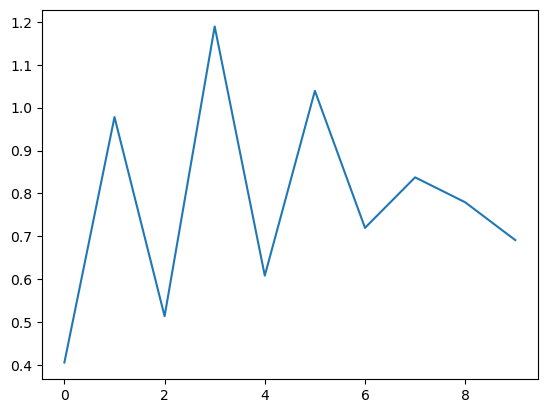

In [11]:
plt.plot(AVERAGE_SIGMA)

In [5]:
import matplotlib.pyplot as plt

In [ ]:
python3 autocorrel.py 0& python3 autocorrel.py 1& python3 autocorrel.py 2& python3 autocorrel.py 3& python3 autocorrel.py 4& python3 autocorrel.py 5&